# Analyze Time-Series

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from zipfile import ZipFile
from pathlib import Path

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [2]:
FOLDER = 'trigger_gor'

## Plotting

In [3]:
colors = [
    "#22223B",
    "#4A4E69",
    "#0B3954",
    "#087E8B",
    "#C81D25",
    "#FF5A5F",
    "#11270b",
    "#3c5a14",
]

def create_bar_plot(labels, values, axis_label=None, title=None,
                    values2=None, axis2_label=None,
                    horizontal=False):

    if len(values) != len(labels):
        raise ValueError("Number of values and labels must be equal.")
    if horizontal and values2 is not None:
        raise ValueError("Cannot have twin axis in a horizontal bar plot.")

    fig, ax1 = plt.subplots(figsize=(5, 3))

    color = colors[2]
    color2 = colors[3]
    if values2 is None:
        width = 0.8
        delta = 0.
    else:
        width = 0.4
        delta = width/2.

    if horizontal:
        ax1.barh(
            labels,
            values,
            color=color,
            edgecolor='black'
        )
    else:
        ax1.bar(
            np.arange(len(labels)) - delta,
            values,
            color=color,
            edgecolor='black',
            width=width,
            align="center",
        )

    if values2 is not None:
        ax2 = ax1.twinx()
        ax2.bar(
            np.arange(len(labels)) + delta,
            values2,
            color=color2,
            edgecolor='black',
            width=width,
            align="center",
        )

    if not horizontal:
        ax1.set_xticks(np.arange(len(labels)))
        ax1.set_xticklabels(labels, rotation=0)
    if axis_label is not None:
        if horizontal:
            ax1.set_xlabel(axis_label, color=color)
        else:
            ax1.set_ylabel(axis_label, color=color)
    if axis2_label is not None:
        ax2.set_ylabel(axis2_label, color=color2)

    if title is not None:
        plt.title(title)
    plt.tight_layout()
    return fig

In [4]:
def plot_reduced_data_subplots(data, filename, n_components=2, title=None):
    pca = PCA(n_components=n_components)
    pca.fit(data)
    data_reduced = pca.transform(data)

    n_plots = int(n_components * (n_components-1) / 2)
    nrows = int((n_plots+1)/2)

    _, axes = plt.subplots(nrows=nrows, ncols=2, figsize=(7, 3*nrows))
    i = 0
    j = 0
    for pc_a in range(n_components-1):
        for pc_b in range(pc_a+1,n_components):
            for n, label in enumerate(labels):
                axes[i,j].scatter(
                    data_reduced[y[0] == (n+1)][:, pc_a],
                    data_reduced[y[0] == (n+1)][:, pc_b],
                    s=6,
                    alpha=0.5,
                    label=label)
            axes[i,j].set_xlabel(f"PC {pc_a+1}")
            axes[i,j].set_ylabel(f"PC {pc_b+1}")
            axes[i,j].legend(loc="upper right", fontsize=6)
            j += 1
            if j == 2:
                j = 0
                i += 1

    plt.tight_layout()
    plt.savefig(f"report/png/{filename}", bbox_inches="tight")
    plt.show()

## Check Data

In [5]:
# Check files needed
folder_path = Path(os.getcwd()) / FOLDER
if not folder_path.is_dir():
    raise ValueError(f"{folder_path} is not a valid folder!")

var_table_file = folder_path / 'var_table.csv'
if not var_table_file.is_file():
    raise ValueError(f"{var_table_file} was not found!")

group_csv_file = folder_path / 'group_csv.zip'
if not group_csv_file.is_file():
    raise ValueError(f"{group_csv_file} was not found!")

all_csv_file = folder_path / 'csv.zip'
if not all_csv_file.is_file():
    # raise ValueError(f"{all_csv_file} was not found!")
    print(f"{all_csv_file} was not found!")
    all_csv_file = None

ValueError: /home/tiago/dev/SimModels/Unisim_iv_2024/dat/sens/trigger_gor/group_csv.zip was not found!

In [7]:
def list_files_zip(zip_file_path):
    file_list = []
    with ZipFile(zip_file_path, 'r') as zip_obj:
        zip_info_list = zip_obj.infolist()
        for zip_info in zip_info_list:
            file_list.append(zip_info.filename)
    return file_list

In [8]:
var_table = pd.read_csv(var_table_file, index_col=0)
n_runs = len(var_table)
print(f'Number of runs: {n_runs}')
for k in var_table.keys():
    print(f'  {k}: {len(set(var_table[k]))} values.')

n_csv_group = len(list_files_zip(group_csv_file))
if n_csv_group != n_runs:
    raise ValueError(f'Number os CSV files in {group_csv_file.name} ({n_csv_group}) does not match master table ({n_runs}).')

if all_csv_file:
    n_csv_all = len(list_files_zip(all_csv_file))
    if n_csv_all != n_runs:
        raise ValueError(f'Number os CSV files in {group_csv_file.name} ({n_csv_all}) does not match master table ({n_runs}).')

Number of runs: 900
  prior: 100 values.
  eos: 1 values.
  kr: 1 values.
  sch: 9 values.


## Fetch Data

In [9]:
def get_variables():
    return list(var_table.keys())

def get_variable_values(k):
    if k in var_table.keys():
        return set(var_table[k])
    return {}

def get_prior(index):
    return var_table.iloc[index,:]['prior']

def get_indexes(filters):
    df = var_table
    for k,v in filters.items():
        df = df[df[k]==v]
    return df.index

def get_df(index, all_data=False):
    zip_file = group_csv_file
    filename = f'sens_{index}_group.csv'
    if all_data:
        if all_csv_file is None:
            raise ValueError(f'{all_csv_file} was not found!')
        zip_file = all_csv_file
        filename = f'sens_{index}.csv'

    file_list = list_files_zip(zip_file)
    if filename not in file_list:
        raise ValueError(f'{filename} was not found in {zip_file.name}!')

    with ZipFile(zip_file, 'r') as zip_obj:
        with zip_obj.open(filename) as f:
            df = pd.read_csv(f)
    return df

def make_composite_df(indexes, column, all_data=False):
    if len(indexes) == 0:
        raise ValueError('At least index is needed.')
    df = get_df(indexes[0], all_data=all_data)
    if column not in df.columns:
        raise ValueError(f'{column} not found in dataframe columns.')
    new_df = pd.DataFrame(columns=df.index)
    new_df.loc[indexes[0]] = df[column].transpose()
    for i in indexes[1:]:
        new_df.loc[i] = get_df(i, all_data=all_data)[column].transpose()
    return new_df

In [10]:
get_df(0).columns

Index(['Date', 'FIELD-PRO:QO', 'FIELD-PRO:QW', 'FIELD-PRO:QG', 'FIELD-PRO:NP',
       'FIELD-PRO:GP', 'FIELD-PRO:WP', 'FIELD-PRO:QO_RC', 'FIELD-PRO:QG_RC',
       'FIELD-PRO:QW_RC', 'FIELD-INJ:QO', 'FIELD-INJ:QW', 'FIELD-INJ:QG',
       'FIELD-INJ:NP', 'FIELD-INJ:GP', 'FIELD-INJ:WP', 'FIELD-INJ:QO_RC',
       'FIELD-INJ:QG_RC', 'FIELD-INJ:QW_RC'],
      dtype='object')

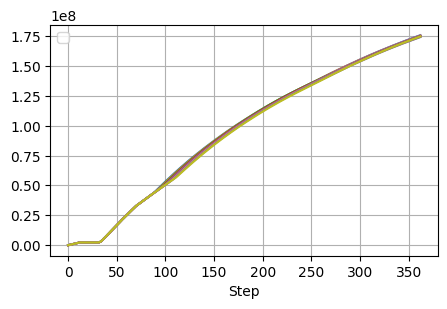

In [11]:
df = make_composite_df(indexes=get_indexes({'prior':48}), column='FIELD-PRO:NP')
df.transpose().plot(kind='line', figsize=(5, 3))
plt.xlabel('Step')
plt.legend([])
plt.grid()
plt.show()

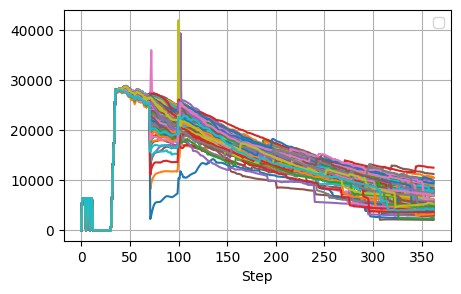

In [72]:
df = make_composite_df(indexes=get_indexes({'sch':'2027.01.01'}), column='FIELD-PRO:QO')
df.transpose().plot(kind='line', figsize=(5, 3))
plt.xlabel('Step')
plt.legend([])
plt.grid()
plt.show()

In [133]:
percentiles = {
    10:[],
    20:[],
    30:[],
    40:[],
    50:[],
    60:[],
    70:[],
    80:[],
    90:[],
    }
for sch in get_variable_values('sch'):
    df = make_composite_df(indexes=get_indexes({'sch':sch}), column='FIELD-PRO:NP')
    ordered_indexes = df.iloc[:,-1].sort_values().index
    for p in percentiles.keys():
        percentiles[p].append(get_prior(ordered_indexes[p-2]))
        percentiles[p].append(get_prior(ordered_indexes[p-1]))
        percentiles[p].append(get_prior(ordered_indexes[p]))

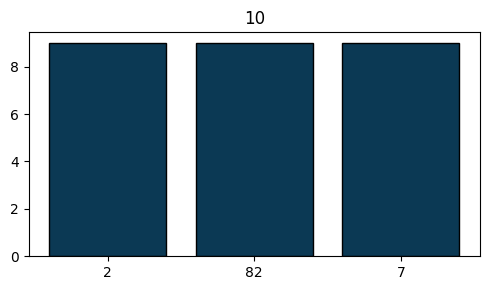

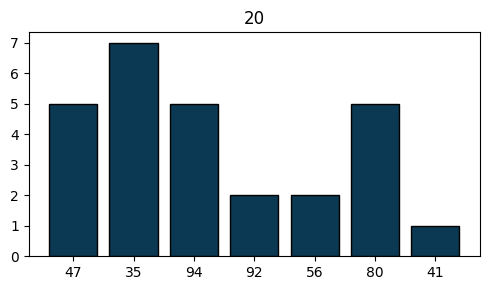

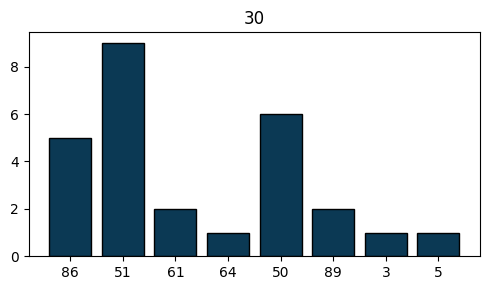

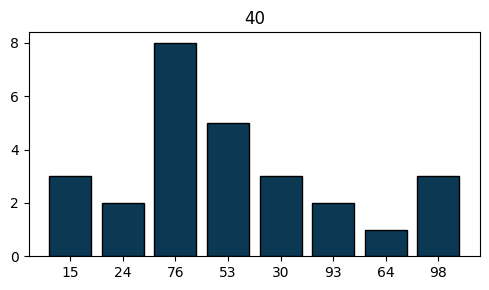

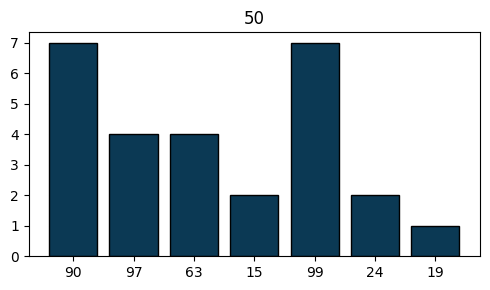

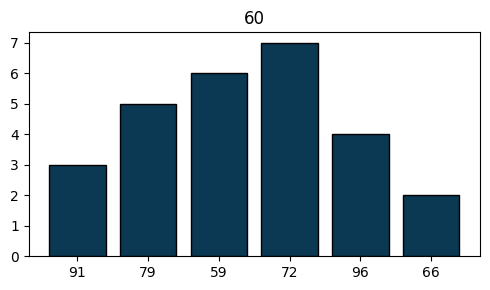

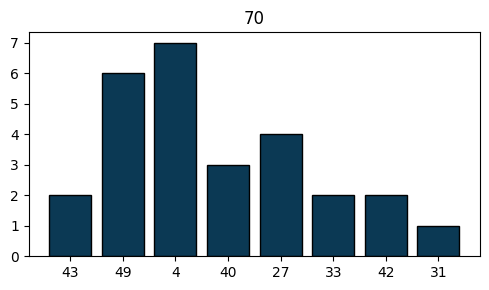

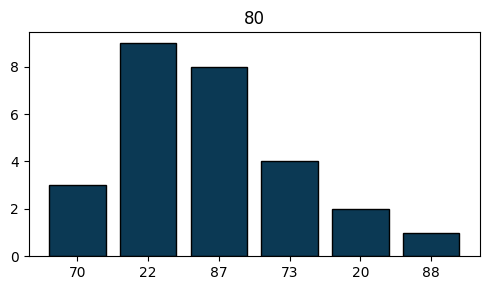

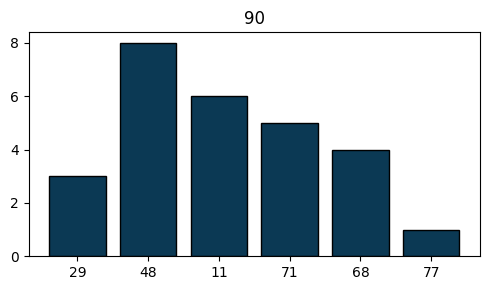

In [134]:
for label,values in percentiles.items():
    value_counts = {}
    for value in values:
        value_counts[value] = value_counts.get(value, 0) + 1

    unique_values = list(value_counts.keys())
    counts = list(value_counts.values())
    create_bar_plot(unique_values, counts, title=label)
    plt.show()

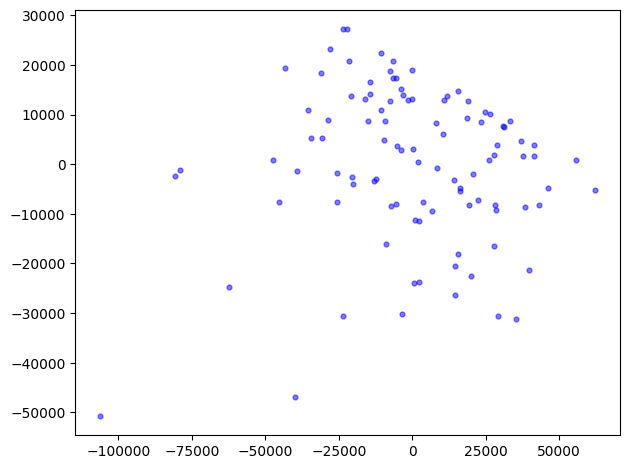

In [89]:
df = make_composite_df(indexes=get_indexes({'sch':'2027.01.01'}), column='FIELD-PRO:QO')

pca = PCA(n_components=2)
pca.fit(df)
data_reduced = pca.transform(df)

plt.scatter(
    data_reduced[:,0],
    data_reduced[:,1],
    color='b',
    marker='o',
    s=12,
    alpha=0.5,
    label='Data Points')
plt.tight_layout()
plt.show()

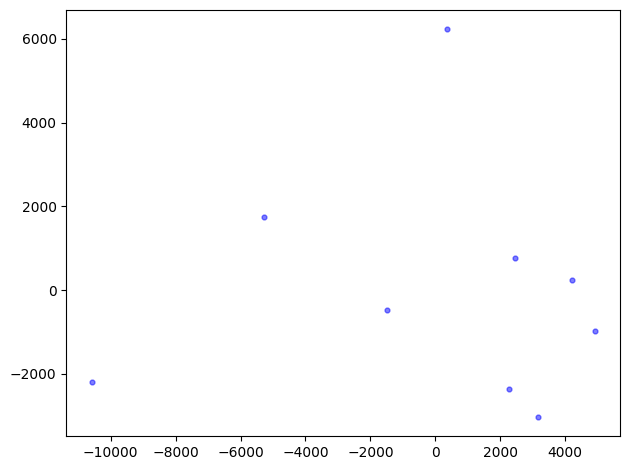

In [12]:
df = make_composite_df(indexes=get_indexes({'prior':1}), column='FIELD-PRO:QO')

pca = PCA(n_components=2)
pca.fit(df)
data_reduced = pca.transform(df)

plt.scatter(
    data_reduced[:,0],
    data_reduced[:,1],
    color='b',
    marker='o',
    s=12,
    alpha=0.5,
    label='Data Points')
plt.tight_layout()
plt.show()

In [11]:
get_df(1)['FIELD-PRO:NP'].iat[-1]

152898683.6295137

In [12]:
get_df(1).columns

Index(['Date', 'FIELD-PRO:QO', 'FIELD-PRO:QW', 'FIELD-PRO:QG', 'FIELD-PRO:NP',
       'FIELD-PRO:GP', 'FIELD-PRO:WP', 'FIELD-PRO:QO_RC', 'FIELD-PRO:QG_RC',
       'FIELD-PRO:QW_RC', 'FIELD-INJ:QO', 'FIELD-INJ:QW', 'FIELD-INJ:QG',
       'FIELD-INJ:NP', 'FIELD-INJ:GP', 'FIELD-INJ:WP', 'FIELD-INJ:QO_RC',
       'FIELD-INJ:QG_RC', 'FIELD-INJ:QW_RC'],
      dtype='object')

In [13]:
get_indexes({'sch':'2027.01.01'})

Index([  4,  13,  22,  31,  40,  49,  58,  67,  76,  85,  94, 103, 112, 121,
       130, 139, 148, 157, 166, 175, 184, 193, 202, 211, 220, 229, 238, 247,
       256, 265, 274, 283, 292, 301, 310, 319, 328, 337, 346, 355, 364, 373,
       382, 391, 400, 409, 418, 427, 436, 445, 454, 463, 472, 481, 490, 499,
       508, 517, 526, 535, 544, 553, 562, 571, 580, 589, 598, 607, 616, 625,
       634, 643, 652, 661, 670, 679, 688, 697, 706, 715, 724, 733, 742, 751,
       760, 769, 778, 787, 796, 805, 814, 823, 832, 841, 850, 859, 868, 877,
       886, 895],
      dtype='int64')

In [14]:
var_table[var_table['prior']==10].index

Index([81, 82, 83, 84, 85, 86, 87, 88, 89], dtype='int64')

In [15]:
get_variables()

['prior', 'eos', 'kr', 'sch']

In [16]:
get_variable_values('sch')

{'2026.01.01',
 '2026.04.01',
 '2026.07.01',
 '2026.10.01',
 '2027.01.01',
 '2027.04.01',
 '2027.07.01',
 '2027.10.01',
 '2028.01.01'}